In [1]:
%matplotlib inline
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns

In [2]:
t = np.linspace(0,10,2000)

In [3]:
k = 2
b = 2
x0 = [5,0]

In [4]:
def fun(xi,t):
    x = xi[0]
    v = xi[1]
    return [xi[1],-k*xi[0]-b*xi[1]]

In [5]:
sol = odeint(fun, x0, t)

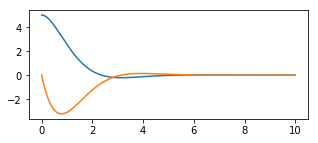

In [6]:
plt.figure(figsize=(5,2))
plt.plot(t,sol)

In [7]:
Sigma = np.array([[5,0],[0,5]])
mu = np.array([0,0])
tau = 0.1
#
N = 40
u = np.linspace(-10,10,N)
v = np.linspace(-10,10,N)
U,V = np.meshgrid(u,v)
#
P = np.zeros((N,N))
P_exp = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        x = np.array([U[i,j],V[i,j]])
        P[i,j] = multivariate_normal.pdf(x,mu,Sigma)
        P_exp[i,j] = 1- np.exp(-tau*np.linalg.norm(x))

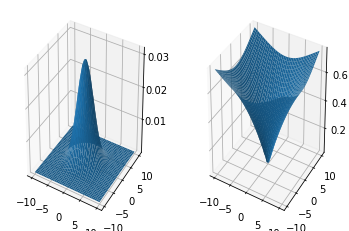

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(U, V, P)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(U, V, P_exp)

In [31]:
def CumExpDist(t,tau):
    return 1 - np.exp(-tau*t)
def SpatialExpDist(x,tau):
    return 1- np.exp(-tau*np.linalg.norm(x))
#
p_sol = np.array([multivariate_normal.pdf(sol[i],mu,Sigma) for i in range(len(sol))])#np.array([SpatialExpDist(sol[i],0.01) for i in range(len(sol))])#
p_t = np.array([CumExpDist(t[i],0.2) for i in range(len(sol))])
P = np.multiply(p_sol,p_t)

In [48]:
Event_flag = np.array([np.random.binomial(1,P[i]) for i in range(len(sol))])

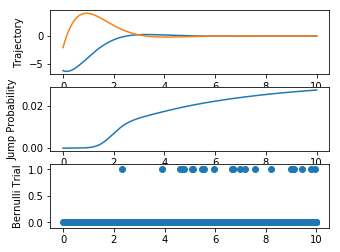

In [49]:
plt.figure(figsize=(5,4))
plt.subplot(311)
plt.plot(t,sol)
plt.ylabel('Trajectory')
plt.subplot(312)
plt.plot(t,P)
plt.ylabel('Jump Probability')
plt.subplot(313)
plt.ylabel('Bernulli Trial')
plt.scatter(t,Event_flag)

In [12]:
Event_index = []
for i in range(len(Event_flag)):
    if Event_flag[i]>0:
        Event_index.append(i)
Event_states = sol[Event_index]

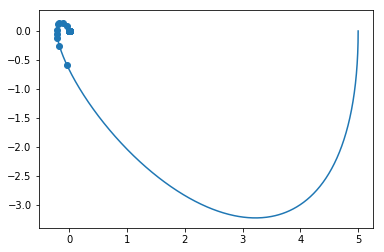

In [13]:
plt.figure()
plt.plot(sol[:,0],sol[:,1])
plt.scatter(Event_states[:,0],Event_states[:,1])

In [14]:
#jump map
def jump(x,t):
    mu = (x + 1*np.random.randn(1,2)).tolist()
    Sigma = [[5,0],[0,5]]
    return np.random.multivariate_normal(mu[0],Sigma)

In [154]:
# integrate the hybrid system
max_events = 5000
event_counter = 0
t = np.linspace(0,10,1000)
x_tot = [0,0,0]
x_event = [0,0,0]
x_reset = [0,0]
t_tot = []
while event_counter<max_events:
    sol = odeint(fun,x0,t)
    for i in range(len(sol)):
        P = multivariate_normal.pdf(sol[i],mu,Sigma)*CumExpDist(t[i],0.4)
        Event = np.random.binomial(1,P)
        if Event:
            flag = 1;
            x0 = jump(sol[i],t[i])
            x_event = np.vstack((x_event,np.hstack((sol[i],t[i]))))
            x_reset = np.vstack((x_reset,x0))
            break
    x_tot = np.vstack((x_tot,np.hstack((sol[:i],t[:i].reshape(i,1)))))
    if event_counter==0:
        t_tot = np.hstack((t_tot,t[:i])) 
        
    else:
        t_tot = np.hstack((t_tot,t[:i]+t_tot[-1]))
    if flag:
        flag = 0
        event_counter += 1
    else:
        x0 = sol[-1]

KeyboardInterrupt: 

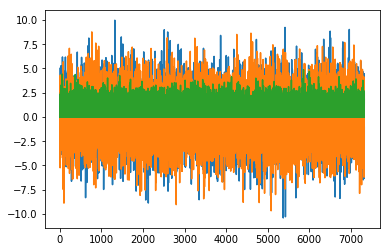

In [16]:
Ttot = t_tot
Xtot = x_tot[1:]
Xtot.shape
plt.figure()
plt.plot(Ttot.reshape(len(Ttot),1),Xtot[:len(Ttot)]);

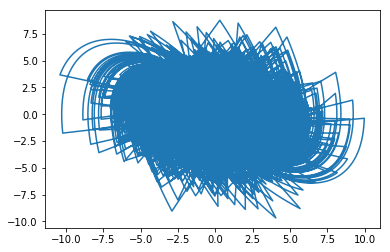

In [17]:
plt.figure()
plt.plot(x_tot[1:,0],x_tot[1:,1]);
plt.scatter(x_event[1:,0],x_event[1:,1]);

<IPython.core.display.Javascript object>


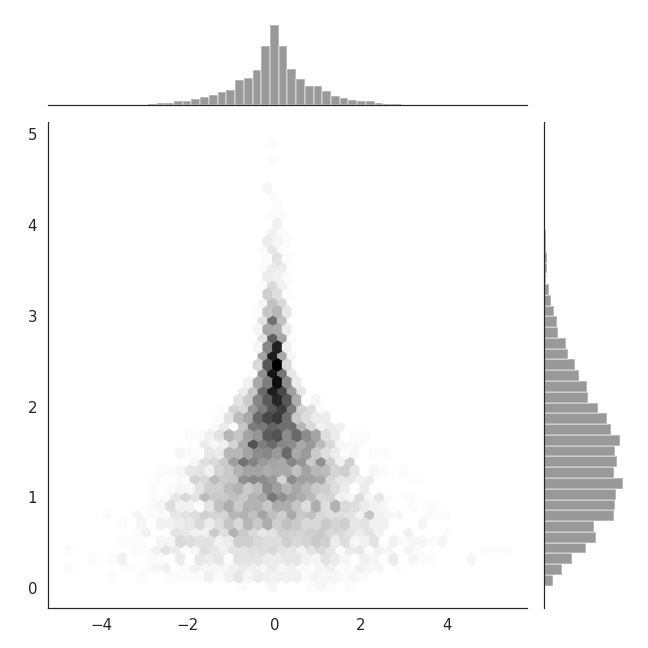

In [78]:
with sns.axes_style("white"):
    sns.jointplot(x=x_event[1:,0], y=x_event[1:,2], kind="hex", color="k");

<IPython.core.display.Javascript object>


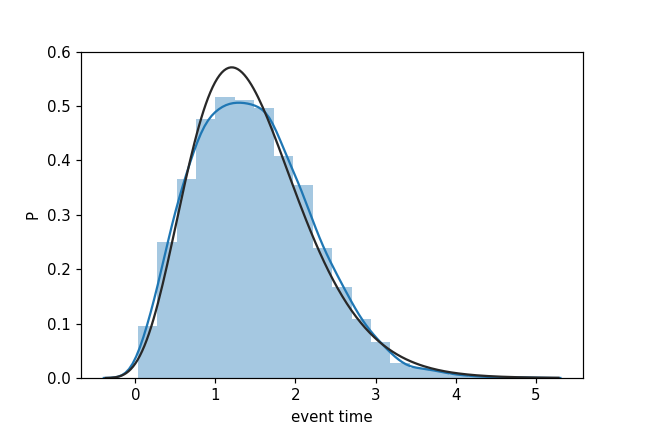

Text(0.5, 0, 'event time')

In [109]:
from scipy.stats import norm
from scipy.stats import gamma
plt.figure()
sns.distplot(x_event[1:,2],bins = 20);
plt.ylabel('P')
plt.xlabel('event time')

<IPython.core.display.Javascript object>


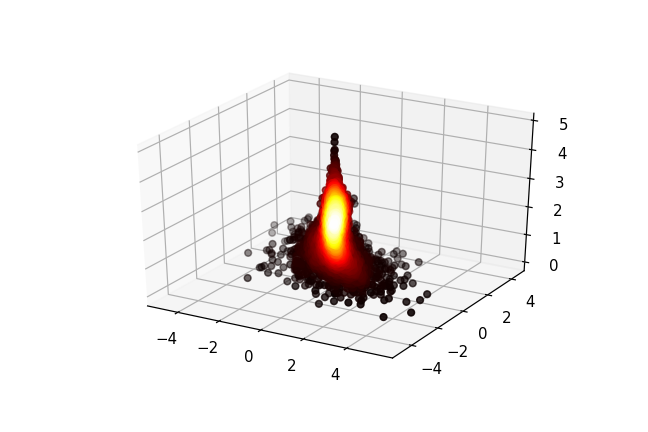

In [75]:
%matplotlib notebook
import matplotlib.pyplot as plt

from scipy import stats
x = x_event[1:,0]
y = x_event[1:,1]
z = x_event[1:,2]

xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=density,cmap=plt.hot())
plt.show()

<IPython.core.display.Javascript object>


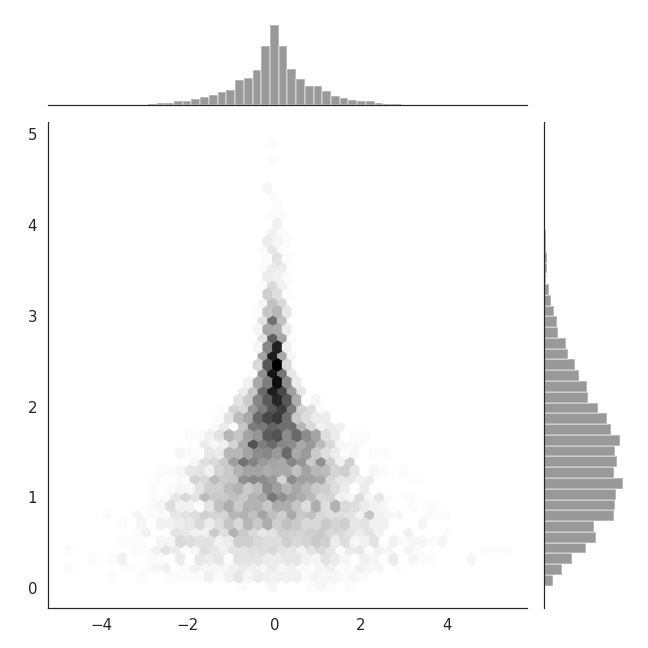

In [98]:
with sns.axes_style("white"):
        sns.jointplot(x=x_event[1:,0], y=x_event[1:,2], kind="hex", color="k");

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

<IPython.core.display.Javascript object>


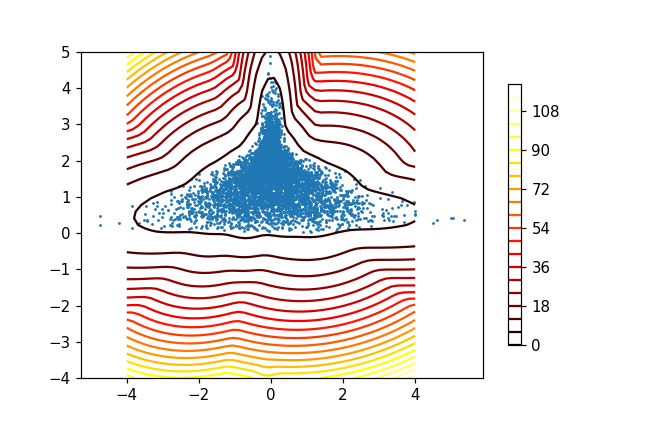

In [99]:
from matplotlib.colors import LogNorm
from sklearn import mixture

# Fit mixure of gaussian
clf = mixture.GaussianMixture(n_components=10, covariance_type='full')
clf.fit(np.hstack((x_event[1:,0].reshape(-1,1),x_event[1:,2].reshape(-1,1))))

x = np.linspace(-4., 4.)
y = np.linspace(-4., 5.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

plt.figure()
CS = plt.contour(X, Y, Z,20)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(x_event[1:,0], x_event[1:,2], .8)
plt.show()

In [92]:
np.hstack((x_event[1:,0].reshape(-1,1),x_event[1:,2].reshape(-1,1)))

array([[ 0.03071916,  2.31231231],
       [ 0.43985979,  1.64164164],
       [-0.44137432,  1.83183183],
       ...,
       [-0.46182885,  1.88188188],
       [-1.87694457,  0.49049049],
       [-1.07162981,  1.81181181]])

In [100]:
#x_event.mean(0)
Se = x_event[1:,:3].T.dot(x_event[1:,:3])/len(x_event)

In [161]:
DXtot = [0]
i = len(Xtot)-1
while i>0:
    if Ttot[i]-Ttot[i-1] == 0:
        Ttot_r = np.delete(Ttot,i-1)
        Xtot_r = np.delete(Xtot,i-1,axis = 0)
        print(i)
    i -= 1

736984
736935
736747
736664
736396
736306
736195
735982
735716
735506
735255
735073
734926
734687
734467
734409
734124
734024
733817
733675
733297
733137
732915
732812
732670
732534
732391
732247
732219
731913
731806
731695
731627
731507
731465
731320
731139
731096
730932
730913
730801
730661
730489
730302
730210
730131
729971
729755
729604
729543
729436
729315
729217
728996
728783
728702
728624
728431
728237
728179
727916
727785
727682
727591
727542
727394
727189
727140
726884
726710
726542
726465
726348
726178
725980
725833
725696
725571
725388
725182
725022
724891
724816
724739
724690
724559
724438
724332
724061
723960
723872
723656
723608
723516
723375
723236
723183
722938
722764
722478
722315
722154
722033
721943
721779
721699
721564
721471
721230
721086
721009
720920
720884
720758
720633
720447
720342
720175
720049
719923
719780
719700
719459
719375
719298
719189
719088
718830
718762
718539
718310
718180
718016
717925
717850
717762
717626
717520
717380
717175
716975
716844
716451

564963
564683
564501
564470
564369
564160
563943
563860
563792
563734
563655
563449
563222
563079
562960
562924
562799
562749
562641
562546
562282
562241
562221
562049
561984
561901
561756
561572
561367
561169
560978
560892
560690
560639
560259
560056
559829
559627
559476
559373
559308
559074
558817
558607
558503
558338
558276
558113
557999
557827
557763
557579
557514
557407
557261
557177
557004
556964
556843
556714
556625
556398
556326
556254
556175
556083
556061
556024
555815
555653
555519
555413
555204
555167
555030
554778
554646
554504
554407
554321
554099
553993
553830
553732
553419
553294
553282
553109
552888
552739
552553
552542
552396
552279
552129
552067
551877
551641
551538
551443
551424
551220
550969
550727
550653
550432
550208
550100
549870
549810
549740
549639
549489
549319
549291
549192
549116
549009
548926
548755
548523
548345
548269
548098
547947
547784
547710
547416
547264
547173
547088
546913
546675
546495
546375
546144
546109
546036
545826
545736
545511
545348
545163

391976
391915
391596
391354
391075
390932
390713
390472
390258
390091
390042
389916
389686
389463
389174
389112
388823
388734
388625
388535
388370
388196
388076
388014
387818
387814
387568
387327
387258
387142
386971
386801
386740
386609
386318
386054
385717
385594
385430
385367
385337
385143
384993
384845
384693
384522
384404
384315
384182
383985
383748
383547
383304
383112
383008
382916
382698
382487
382279
382169
382035
381783
381719
381684
381605
381482
381269
381064
380904
380665
380551
380401
380236
380041
379947
379845
379688
379456
379378
379277
379155
379005
378855
378570
378343
378254
378182
378070
377912
377846
377816
377680
377495
377304
377183
376982
376835
376784
376710
376511
376432
376273
376185
376016
375906
375763
375657
375498
375366
375308
375270
375028
374796
374633
374468
374345
374130
373943
373872
373699
373417
373349
373258
373205
372973
372743
372484
372308
372227
372034
371946
371777
371580
371281
371211
371096
370977
370928
370666
370502
370443
370325
369985

217513
217369
217280
217137
217015
216873
216752
216541
216421
216388
216228
216182
216061
215882
215796
215543
215336
215179
215022
214933
214672
214621
214474
214406
214280
214062
213849
213701
213651
213537
213419
213292
213051
212756
212699
212613
212366
212259
212192
212040
211886
211801
211546
211388
211125
211067
210852
210715
210602
210390
210124
209889
209627
209384
209266
209029
208944
208774
208629
208435
208177
208098
207836
207782
207581
207351
207177
207074
206979
206862
206707
206627
206458
206393
206263
206053
205984
205943
205789
205764
205664
205543
205294
205037
204986
204884
204794
204514
204315
204185
204059
203972
203853
203687
203575
203349
203203
203007
202922
202742
202664
202586
202399
202190
202134
202002
201853
201793
201648
201447
201159
201126
200840
200714
200604
200393
200335
200100
200044
199900
199814
199631
199610
199558
199466
199435
199224
199025
198894
198778
198411
198211
197914
197700
197470
197394
197273
197097
196980
196673
196487
196174
196074

35972
35798
35644
35404
35211
35144
35019
34747
34623
34512
34439
34394
34283
34016
33955
33857
33791
33510
33333
33253
33083
32933
32717
32480
32383
32300
32041
31857
31752
31662
31493
31327
31209
31045
30881
30828
30680
30584
30465
30304
30034
29938
29836
29653
29394
29139
28948
28827
28726
28544
28395
28312
28277
28062
27979
27818
27634
27433
27383
27203
27146
27101
26942
26795
26685
26483
26346
26285
26231
26063
25856
25509
25352
25116
24973
24940
24783
24669
24559
24424
24165
24044
23870
23763
23501
23426
23322
23303
23178
23139
23096
23014
22875
22845
22608
22508
22392
22316
22191
22029
21928
21739
21698
21623
21503
21402
21302
21119
20990
20818
20586
20516
20352
20134
20041
19797
19621
19505
19305
19076
18872
18729
18624
18494
18353
18186
18168
17955
17629
17525
17453
17081
16964
16783
16731
16683
16547
16365
16313
16228
16192
15989
15915
15752
15694
15625
15533
15457
15185
15134
15037
14994
14855
14734
14483
14306
14259
14088
13861
13790
13695
13670
13506
13295
13255
13076
1281

ValueError: operands could not be broadcast together with shapes (737163,3) (737163,) 

In [168]:
DeltaXtot = Xtot_r[1:]-Xtot_r[:-1]
DXtot = [np.linalg.norm(p) for p in DeltaXtot]

<IPython.core.display.Javascript object>


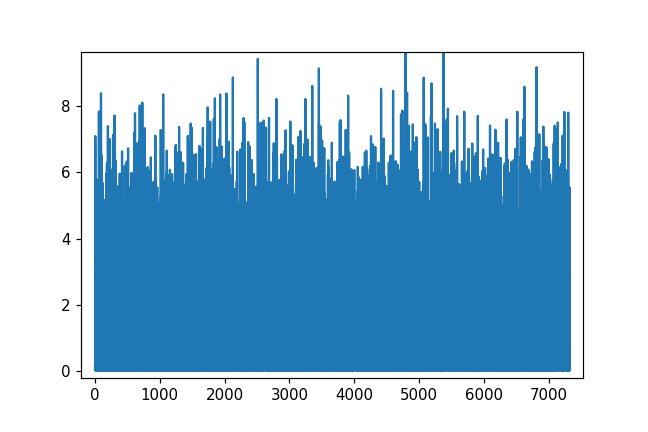

In [169]:
plt.figure()
plt.plot(Ttot_r[1:],DXtot)